# Librerias

In [ ]:
!pip install xgboost  


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   --- ------------------------------------ 13.1/150.0 MB 75.1 MB/s eta 0:00:02
   ------- -------------------------------- 28.6/150.0 MB 69.7 MB/s eta 0:00:02
   ----------- ---------------------------- 42.2/150.0 MB 68.9 MB/s eta 0:00:02
   --------------- ------------------------ 57.7/150.0 MB 69.3 MB/s eta 0:00:02
   ------------------- -------------------- 72.6/150.0 MB 70.2 MB/s eta 0:00:02
   ----------------------- ---------------- 87.3/150.0 MB 70.5 MB/s eta 0:00:01
   -------------------------- ------------ 102.2/150.0 MB 70.2 MB/s eta 0:00:01
   ------------------------------ -------- 116.7/150.0 MB 69.7 MB/s eta 0:00:01
   ---------------------------------- ---- 132.6/150.0 MB 70.6 MB/s eta 0:00:01
   --------------------------------------  149.4/150.0 MB 71.3 MB/s eta 0:00:01
   --------------------------------------- 150.0/15

In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import shutil
import joblib
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import cv2
import joblib

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, adjusted_rand_score, homogeneity_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Modelos
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# XGBoost
import xgboost
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from scipy.stats import uniform, randint


# Semilla global (opcional)
RANDOM_STATE = 42



# Carga de datos

In [2]:
base_dir = r'..\Imagenes'
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'validation')
test_dir  = os.path.join(base_dir, 'test')

classes = ['Healthy_Leaf_Rose', 'Rose_Rust', 'Rose_sawfly_Rose_slug']

In [3]:
def count_images_in_folder(folder_path):
    exts = ['*.jpg', '*.jpeg', '*.png']
    count = 0
    for ext in exts:
        count += len(glob(os.path.join(folder_path, ext)))
    return count

print("Distribución de imágenes:")
for subset in ['train', 'validation', 'test']:
    print(f"\n{subset.upper()}:")
    subset_dir = os.path.join(base_dir, subset)
    for cls in classes:
        cls_path = os.path.join(subset_dir, cls)
        num_imgs = count_images_in_folder(cls_path)
        print(f" - {cls}: {num_imgs} imágenes")

Distribución de imágenes:

TRAIN:
 - Healthy_Leaf_Rose: 2450 imágenes
 - Rose_Rust: 2450 imágenes
 - Rose_sawfly_Rose_slug: 2450 imágenes

VALIDATION:
 - Healthy_Leaf_Rose: 2450 imágenes
 - Rose_Rust: 2450 imágenes
 - Rose_sawfly_Rose_slug: 2450 imágenes

TEST:
 - Healthy_Leaf_Rose: 78 imágenes
 - Rose_Rust: 53 imágenes
 - Rose_sawfly_Rose_slug: 79 imágenes


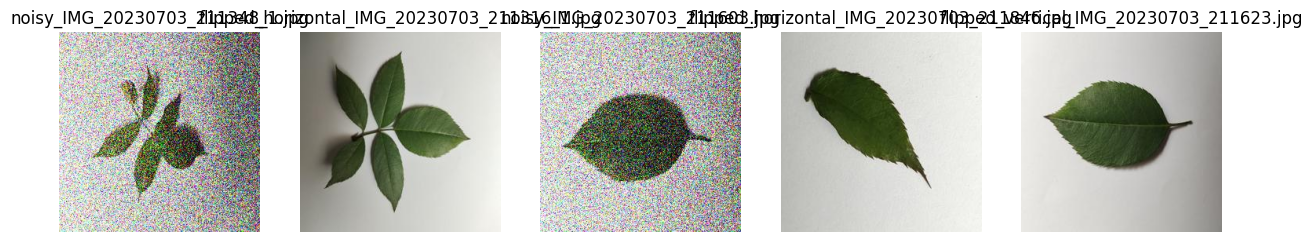

In [ ]:
def load_images_from_folder(folder_path, max_imgs=None):
    exts = ['*.jpg', '*.jpeg', '*.png']
    image_paths = []
    for ext in exts:
        image_paths.extend(glob(os.path.join(folder_path, ext)))
    if max_imgs is not None:
        image_paths = image_paths[:max_imgs]

    images = []
    for p in image_paths:
        img = cv2.imread(p)
        if img is not None:
            images.append(img)
    return images, image_paths
def show_random_images(folder_path, n=5):
    images, paths = load_images_from_folder(folder_path)
    if not images:
        print("No hay imágenes en la carpeta.")
        return
    chosen = random.sample(range(len(images)), min(n, len(images)))
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(chosen):
        img_bgr = images[idx]
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img_rgb)
        plt.axis('off') 
        plt.title(os.path.basename(paths[idx]))
    plt.show()

show_random_images(os.path.join(train_dir, 'Healthy_Leaf_Rose'), n=5)

# 1. Transformaciones Geométricas y Data Augmentation


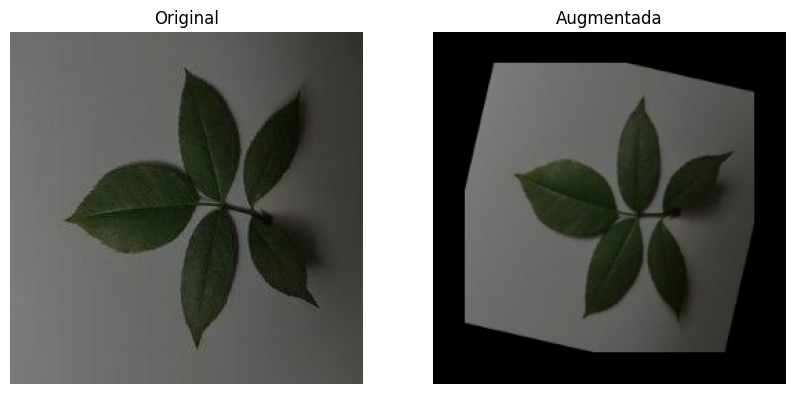

In [ ]:
def augment_image(img):
    # Rotación aleatoria
    angle = random.uniform(-30, 30)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    
    # Flip aleatorio
    flip_type = random.choice([0, 1, -1])  # 0: vertical, 1: horizontal, -1: ambos
    flipped = cv2.flip(rotated, flip_type)
    
    # Escalado (zoom in/out)
    scale = random.uniform(0.8, 1.2)
    new_w, new_h = int(w * scale), int(h * scale)
    scaled = cv2.resize(flipped, (new_w, new_h))
    
    # Ajustar a tamaño original
    if new_w < w:
        # Centramos la imagen en un lienzo de tamaño original
        canvas = np.zeros_like(img)
        start_x = (w - new_w)//2
        start_y = (h - new_h)//2
        canvas[start_y:start_y+new_h, start_x:start_x+new_w] = scaled
        result = canvas
    else:
        # Recortamos el centro
        start_x = (new_w - w)//2
        start_y = (new_h - h)//2
        result = scaled[start_y:start_y+h, start_x:start_x+w]
    
    return result

# Probar la función de augment con una imagen
some_imgs, _ = load_images_from_folder(os.path.join(train_dir, 'Healthy_Leaf_Rose'), max_imgs=1)
if some_imgs:
    img_test = some_imgs[0]
    aug_img = augment_image(img_test)
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Augmentada")
    axs[1].axis('off')

    plt.show()
    


In [ ]:
augmented_dir = os.path.join(base_dir, 'train_augmented')

# Crear carpeta de salida si no existe
os.makedirs(augmented_dir, exist_ok=True)

# Cantidad de imágenes augmentadas por imagen original
AUG_PER_IMAGE = 2

def save_augmented_dataset():
    for cls in classes:
        input_cls_path = os.path.join(train_dir, cls)
        output_cls_path = os.path.join(augmented_dir, cls)
        os.makedirs(output_cls_path, exist_ok=True)

        # Obtener imágenes
        image_paths = glob(os.path.join(input_cls_path, '*.jpg')) + \
                      glob(os.path.join(input_cls_path, '*.jpeg')) + \
                      glob(os.path.join(input_cls_path, '*.png'))

        for img_path in tqdm(image_paths, desc=f"Procesando clase: {cls}"):
            filename = os.path.basename(img_path)
            img = cv2.imread(img_path)

            if img is None:
                print(f"No se pudo leer: {img_path}")
                continue

            # Guardar imagen original también (opcional)
            base_name, ext = os.path.splitext(filename)
            original_save_path = os.path.join(output_cls_path, f"original_{base_name}{ext}")
            cv2.imwrite(original_save_path, img)

            # Generar N versiones aumentadas
            for i in range(AUG_PER_IMAGE):
                aug_img = augment_image(img)
                aug_filename = f"aug_{i}_{base_name}{ext}"
                aug_path = os.path.join(output_cls_path, aug_filename)
                cv2.imwrite(aug_path, aug_img)

    print(" Data augmentation finalizado.")
save_augmented_dataset()


Procesando clase: Rose_sawfly_Rose_slug: 100%|██████████| 2450/2450 [00:30<00:00, 81.09it/s] 

 Data augmentation finalizado.


# 2. Filtrado y Convolución Aplicar filtros de suavizado o filtros de borde (Prewitt, Sobel) para resaltar características

In [ ]:
def apply_filters_to_augmented_dataset():
    input_base = os.path.join(base_dir, 'train_augmented')
    output_base = os.path.join(base_dir, 'train_filtered')
    os.makedirs(output_base, exist_ok=True)

    for cls in classes:
        input_cls_path = os.path.join(input_base, cls)
        output_cls_path = os.path.join(output_base, cls)
        os.makedirs(output_cls_path, exist_ok=True)

        image_paths = glob(os.path.join(input_cls_path, '*.jpg')) + \
                      glob(os.path.join(input_cls_path, '*.jpeg')) + \
                      glob(os.path.join(input_cls_path, '*.png'))

        for img_path in tqdm(image_paths, desc=f"Filtrando clase: {cls}"):
            img = cv2.imread(img_path)
            if img is None:
                continue

            # 1. Suavizado (Gaussian Blur)
            blurred = cv2.GaussianBlur(img, (5, 5), 0)

            # 2. Convertir a gris para detección de bordes
            gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

            # 3. Filtro Sobel
            sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
            sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
            sobel = cv2.magnitude(sobel_x, sobel_y)
            sobel = np.uint8(np.clip(sobel, 0, 255))

            # 4. Filtro Prewitt (manual)
            kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
            kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
            prewitt_x = cv2.filter2D(gray, -1, kernelx)
            prewitt_y = cv2.filter2D(gray, -1, kernely)
            prewitt = cv2.magnitude(prewitt_x.astype(np.float32), prewitt_y.astype(np.float32))
            prewitt = np.uint8(np.clip(prewitt, 0, 255))

            # Guardar imágenes
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            cv2.imwrite(os.path.join(output_cls_path, f"{base_name}_blurred.jpg"), blurred)
            cv2.imwrite(os.path.join(output_cls_path, f"{base_name}_sobel.jpg"), sobel)
            cv2.imwrite(os.path.join(output_cls_path, f"{base_name}_prewitt.jpg"), prewitt)

    print(" Filtrado finalizado.")
apply_filters_to_augmented_dataset()


Filtrando clase: Rose_sawfly_Rose_slug: 100%|██████████| 7350/7350 [01:58<00:00, 62.08it/s]

 Filtrado finalizado.


## 3. Detección de bordes y umbralización: Implementación de Canny, Laplacian, Otsu, etc.


In [ ]:
def apply_edge_detection_and_thresholding():
    input_base = os.path.join(base_dir, 'train_augmented')
    output_base = os.path.join(base_dir, 'train_edges')
    os.makedirs(output_base, exist_ok=True)

    for cls in classes:
        input_cls_path = os.path.join(input_base, cls)
        output_cls_path = os.path.join(output_base, cls)
        os.makedirs(output_cls_path, exist_ok=True)

        image_paths = glob(os.path.join(input_cls_path, '*.jpg')) + \
                      glob(os.path.join(input_cls_path, '*.jpeg')) + \
                      glob(os.path.join(input_cls_path, '*.png'))

        for img_path in tqdm(image_paths, desc=f"Bordes/Umbralización - clase: {cls}"):
            img = cv2.imread(img_path)
            if img is None:
                continue

            # Convertir a escala de grises
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # 1. Canny
            canny = cv2.Canny(gray, 100, 200)

            # 2. Laplacian
            laplacian = cv2.Laplacian(gray, cv2.CV_64F)
            laplacian = np.uint8(np.absolute(laplacian))

            # 3. Otsu (umbral binario)
            _, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Guardar
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            cv2.imwrite(os.path.join(output_cls_path, f"{base_name}_canny.jpg"), canny)
            cv2.imwrite(os.path.join(output_cls_path, f"{base_name}_laplacian.jpg"), laplacian)
            cv2.imwrite(os.path.join(output_cls_path, f"{base_name}_otsu.jpg"), otsu)

    print(" Detección de bordes y umbralización finalizada.")
apply_edge_detection_and_thresholding()


Bordes/Umbralización - clase: Rose_Rust: 100%|██████████| 7350/7350 [00:28<00:00, 254.09it/s]
Bordes/Umbralización - clase: Rose_sawfly_Rose_slug: 100%|██████████| 7350/7350 [00:36<00:00, 200.45it/s]

 Detección de bordes y umbralización finalizada.


## 4.Ecualización de Histogramas: Mejorar la iluminación de las imágenes antes de extraer características o entrenar modelos

In [ ]:
def apply_histogram_equalization():
    input_base = os.path.join(base_dir, 'train_augmented')
    output_base = os.path.join(base_dir, 'train_equalized')
    os.makedirs(output_base, exist_ok=True)

    for cls in classes:
        input_cls_path = os.path.join(input_base, cls)
        output_cls_path = os.path.join(output_base, cls)
        os.makedirs(output_cls_path, exist_ok=True)

        image_paths = glob(os.path.join(input_cls_path, '*.jpg')) + \
                      glob(os.path.join(input_cls_path, '*.jpeg')) + \
                      glob(os.path.join(input_cls_path, '*.png'))

        for img_path in tqdm(image_paths, desc=f"Ecualizando clase: {cls}"):
            img = cv2.imread(img_path)
            if img is None:
                continue

            # Convertir a YCrCb y ecualizar canal de luminancia (Y)
            ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            y_channel, cr, cb = cv2.split(ycrcb)
            y_eq = cv2.equalizeHist(y_channel)
            ycrcb_eq = cv2.merge((y_eq, cr, cb))
            img_eq = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

            # Guardar imagen ecualizada
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            save_path = os.path.join(output_cls_path, f"{base_name}_eq.jpg")
            cv2.imwrite(save_path, img_eq)

    print(" Ecualización de histograma finalizada.")
apply_histogram_equalization()


Ecualizando clase: Rose_sawfly_Rose_slug: 100%|██████████| 7350/7350 [00:27<00:00, 269.54it/s]

 Ecualización de histograma finalizada.


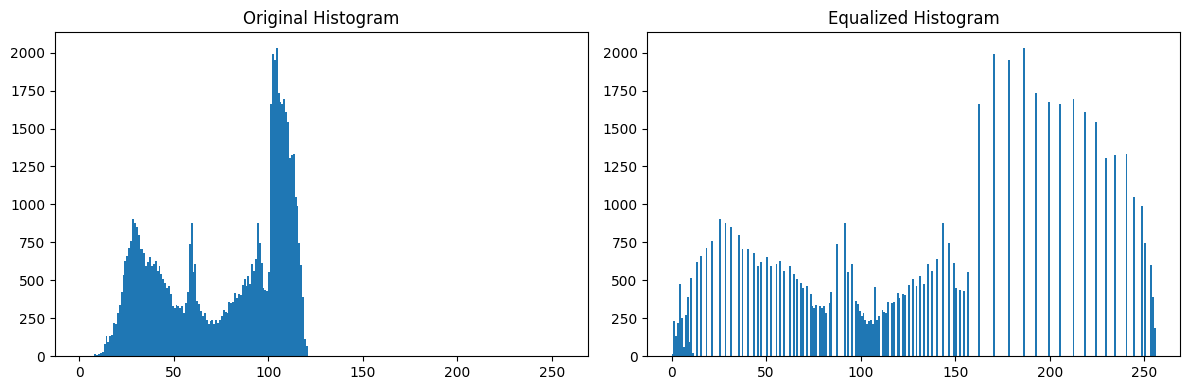

In [ ]:
def plot_histograms(original, equalized):
    plt.figure(figsize=(12, 4))

    # Original
    plt.subplot(1, 2, 1)
    plt.hist(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY).ravel(), bins=256, range=(0, 256))
    plt.title("Original Histogram")

    # Ecualizado
    plt.subplot(1, 2, 2)
    plt.hist(cv2.cvtColor(equalized, cv2.COLOR_BGR2GRAY).ravel(), bins=256, range=(0, 256))
    plt.title("Equalized Histogram")

    plt.tight_layout()
    plt.show()
# 1. Cargar una imagen original (por ejemplo de train_augmented)
img_path = os.path.join(base_dir, 'train_augmented', 'Healthy_Leaf_Rose')
image_files = glob(os.path.join(img_path, '*.jpg'))
original = cv2.imread(image_files[0])  # Usamos la primera imagen

# 2. Ecualizar la imagen (modo YCrCb para color)
ycrcb = cv2.cvtColor(original, cv2.COLOR_BGR2YCrCb)
y, cr, cb = cv2.split(ycrcb)
y_eq = cv2.equalizeHist(y)
ycrcb_eq = cv2.merge((y_eq, cr, cb))
equalized = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

# 3. Llamar a la función de visualización
plot_histograms(original, equalized)


## 5.Feature Detection y Descriptores (SIFT, SURF) Extracción de puntos clave para clasificadores

In [ ]:
def combine_all_processed_images():
    sources = ['train_augmented', 'train_filtered', 'train_edges', 'train_equalized']
    destination = os.path.join(base_dir, 'train_final')
    os.makedirs(destination, exist_ok=True)

    for cls in classes:
        dest_cls_path = os.path.join(destination, cls)
        os.makedirs(dest_cls_path, exist_ok=True)

        for source in sources:
            source_cls_path = os.path.join(base_dir, source, cls)
            if not os.path.exists(source_cls_path):
                continue

            image_paths = glob(os.path.join(source_cls_path, '*.*'))

            for img_path in image_paths:
                filename = os.path.basename(img_path)
                # Añadir prefijo para evitar colisiones
                new_filename = f"{source}_{filename}"
                new_path = os.path.join(dest_cls_path, new_filename)
                shutil.copyfile(img_path, new_path)

    print(" Imágenes combinadas en 'train_final'")
combine_all_processed_images()


 Imágenes combinadas en 'train_final'


In [ ]:
def extract_sift_descriptors(dataset_dir):
    sift = cv2.SIFT_create(nfeatures=500)
    descriptors_list = []
    labels_list = []

    for cls in classes:
        cls_path = os.path.join(dataset_dir, cls)
        image_paths = glob(os.path.join(cls_path, '*.jpg')) + \
                      glob(os.path.join(cls_path, '*.jpeg')) + \
                      glob(os.path.join(cls_path, '*.png'))

        print(f" Procesando clase: {cls} ({len(image_paths)} imágenes)")

        for img_path in tqdm(image_paths):
            img = cv2.imread(img_path)
            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            keypoints, descriptors = sift.detectAndCompute(gray, None)

            if descriptors is not None:
                descriptors_list.append(descriptors)
                labels_list.append(cls)

    print(" Extracción de descriptores finalizada.")
    return descriptors_list, labels_list
final_dir = os.path.join(base_dir, 'train_final')
descriptors_list, labels_list = extract_sift_descriptors(final_dir)
joblib.dump((descriptors_list, labels_list), 'sift_descriptors.pkl')


 Procesando clase: Healthy_Leaf_Rose (58800 imágenes)


100%|██████████| 58800/58800 [33:40<00:00, 29.09it/s] 


 Procesando clase: Rose_Rust (58800 imágenes)


100%|██████████| 58800/58800 [3:13:25<00:00,  5.07it/s]      


 Procesando clase: Rose_sawfly_Rose_slug (58800 imágenes)


100%|██████████| 58800/58800 [2:59:51<00:00,  5.45it/s]     


 Extracción de descriptores finalizada.


['sift_descriptors.pkl']

In [ ]:
descriptors_list, labels_list = joblib.load('sift_descriptors.pkl')


## 6.Bag of Visual Words (BoVW) o VLAD Construcción de un vocabulario visual a partir de descriptores de puntos clave.


In [ ]:

def build_vocabulary_minibatch(descriptors_list, k=100, batch_size=1000):
    all_desc = np.vstack(descriptors_list)
    print(f" Total de descriptores: {all_desc.shape[0]}")

    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=42, verbose=1)
    kmeans.fit(all_desc)

    print(" Vocabulario visual generado con MiniBatchKMeans.")
    return kmeans
def compute_bovw_histograms(kmeans, descriptors_list, k):
    histograms = []

    for descriptors in descriptors_list:
        if descriptors is None or len(descriptors) == 0:
            histograms.append(np.zeros(k))  # vector vacío si no hay descriptores
            continue

        visual_words = kmeans.predict(descriptors)
        hist, _ = np.histogram(visual_words, bins=np.arange(k+1), density=True)
        histograms.append(hist)

    return np.array(histograms)


k = 100
kmeans = build_vocabulary_minibatch(descriptors_list, k)
X_bovw = compute_bovw_histograms(kmeans, descriptors_list, k)




# Convertir etiquetas a números

le = LabelEncoder()
y_labels = le.fit_transform(labels_list)


🔢 Total de descriptores: 23096727
Init 1/1 with method k-means++
Inertia for init 1/1: 297022016.0
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 1/2309672: mean batch inertia: 98999.008
Minibatch step 2/2309672: mean batch inertia: 73508.464, ewa inertia: 73508.464
[MiniBatchKMeans] Reassigning 4 cluster centers.
Minibatch step 3/2309672: mean batch inertia: 72747.104, ewa inertia: 73508.39807204693
Minibatch step 4/2309672: mean batch inertia: 72430.488, ewa inertia: 73508.3047332786
[MiniBatchKMeans] Reassigning 2 cluster centers.
Minibatch step 5/2309672: mean batch inertia: 70634.12, ewa inertia: 73508.05585086258
Minibatch step 6/2309672: mean batch inertia: 66443.92, ewa inertia: 73507.44415072472
Minibatch step 7/2309672: mean batch inertia: 71651.048, ewa inertia: 73507.28340101587
Minibatch step 8/2309672: mean batch inertia: 68925.752, ewa inertia: 73506.8866754363
Minibatch step 9/2309672: mean batch inertia: 68946.208, ewa inertia: 73506.49175554328
Miniba

In [ ]:
joblib.dump(kmeans, 'bovw_kmeans_model.pkl')
joblib.dump((X_bovw, y_labels), 'bovw_features_labels.pkl')


['bovw_features_labels.pkl']

In [ ]:
print("Forma del vocabulario:", kmeans.cluster_centers_.shape)
# (k, 128) → 100 x 128 si k=100


Forma del vocabulario: (100, 128)


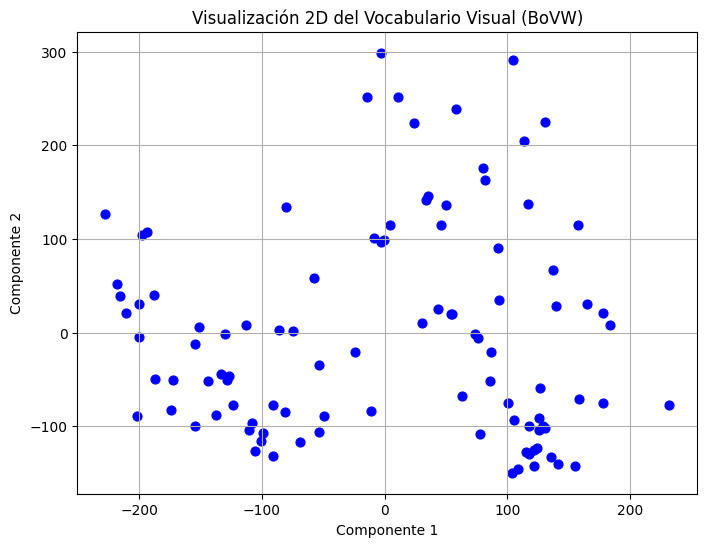

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(kmeans.cluster_centers_)

plt.figure(figsize=(8,6))
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], c='blue', s=40)
plt.title("Visualización 2D del Vocabulario Visual (BoVW)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()


## 7. Machine Learning Pipeline en Scikit-Learn

In [26]:
# X_bovw: numpy array de shape (n_samples, k)  # k = #clusters BoVW
# y_labels: numpy array de shape (n_samples,)
X_bovw, y_labels = joblib.load('Models\\bovw_features_labels.pkl')

print("X_bovw shape:", X_bovw.shape)
print("y_labels shape:", y_labels.shape)


X_bovw shape: (175886, 100)
y_labels shape: (175886,)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bovw, y_labels, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)


Train set: (140708, 100) Test set: (35178, 100)


## Pipeline

In [13]:
pipelines = {
    'svm': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LinearSVC(random_state=RANDOM_STATE, max_iter=2000))
    ]),
    'rf': Pipeline([
        ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
    ]),
    'xgb': Pipeline([
        ('clf', XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=RANDOM_STATE
            # Si quieres GPU: tree_method='gpu_hist', predictor='gpu_predictor'
        ))
    ]),
    'knn': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ]),
    'dt': Pipeline([
        ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]),
}

# Definimos distribuciones de hiperparámetros
# Usamos rangos un poco más amplios para "exprimir" más.
param_distributions = {
    'svm': {
        'clf__C': [0.1, 1, 10, 100, 300, 500]
    },
    'rf': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10]
    },
    'xgb': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 6, 10, 12],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__subsample': [0.7, 0.8, 1.0],
        'clf__colsample_bytree': [0.7, 0.8, 1.0]
    },
    'knn': {
        'clf__n_neighbors': [3, 5, 7, 9, 11],
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2]  # distancia Manhattan (p=1) o Euclídea (p=2)
    },
    'dt': {
        'clf__max_depth': [None, 5, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10, 15]
    }
}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import time

best_models = []
top_n = 3  

for model_name, pipeline in pipelines.items():
    print(f"\n===== Entrenando modelo (v2): {model_name.upper()} =====")
    distr = param_distributions[model_name]
    
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=distr,
        n_iter=15,             
        cv=5,                  
        n_jobs=-1,            
        verbose=3,            
        scoring='accuracy',
        random_state=RANDOM_STATE
    )

    start_time = time.time()
    random_search.fit(X_train, y_train)
    elapsed = time.time() - start_time
    print(f"⏱  Tiempo {model_name}: {elapsed/60:.2f} minutos")

    # Mejor combinación
    print(f"Mejor score (cv) para {model_name}: {random_search.best_score_:.4f}")
    print(f"Mejores hiperparámetros: {random_search.best_params_}")

    # Evaluar en test
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    print(f"Exactitud en test para {model_name}: {acc_test:.4f}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Guardar info de este modelo
    model_info = {
        'model_name': model_name,
        'cv_score': random_search.best_score_,
        'test_accuracy': acc_test,
        'model': best_model
    }
    best_models.append(model_info)

    # Guardar el mejor modelo actual con sufijo _v2
    model_filename = f"{model_name}_v2_best_model.pkl"
    joblib.dump(best_model, model_filename)
    print(f"Modelo guardado en {model_filename}")

# Ordenar todos los modelos por exactitud en test
best_models_sorted = sorted(best_models, key=lambda x: x['test_accuracy'], reverse=True)

# Guardar los 3 mejores con sufijo _v2_top_i
for i in range(top_n):
    model_info = best_models_sorted[i]
    print(f"\nTOP {i+1} (v2): Modelo {model_info['model_name']} con test accuracy {model_info['test_accuracy']:.4f}")
    file_top = f"{model_info['model_name']}_v2_top_{i+1}.pkl"
    joblib.dump(model_info['model'], file_top)
    print(f"Guardado como {file_top}")



===== Entrenando modelo (v2): SVM =====
Fitting 5 folds for each of 6 candidates, totalling 30 fits
⏱  Tiempo svm: 1.03 minutos
Mejor score (cv) para svm: 0.7346
Mejores hiperparámetros: {'clf__C': 0.1}
Exactitud en test para svm: 0.7335
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74     11681
           1       0.73      0.80      0.76     11699
           2       0.73      0.66      0.70     11798

    accuracy                           0.73     35178
   macro avg       0.73      0.73      0.73     35178
weighted avg       0.73      0.73      0.73     35178

Confusion Matrix:
[[8690 1382 1609]
 [1172 9320 1207]
 [1988 2017 7793]]
Modelo guardado en svm_v2_best_model.pkl

===== Entrenando modelo (v2): RF =====
Fitting 5 folds for each of 15 candidates, totalling 75 fits
⏱  Tiempo rf: 10.01 minutos
Mejor score (cv) para rf: 0.8983
Mejores hiperparámetros: {'clf__n_estimators': 300, 'clf__min_samples_split': 2, 

In [19]:
class_dict = {
    0: "Healthy_Leaf_Rose",
    1: "Rose_Rust",
    2: "Rose_Sawfly"
}

In [20]:
def compute_bovw_for_image(img_bgr, sift, kmeans):
    """
    1. Convierte a gris
    2. Extrae descriptores SIFT
    3. Clusteriza cada descriptor con kmeans.predict
    4. Hace un histograma normalizado
    5. Retorna ese vector BoVW
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None or len(descriptors) == 0:
        # Si no hay descriptores, retornamos un vector de 0
        k = kmeans.n_clusters
        return np.zeros((k,), dtype=np.float32)

    # Predecir las "palabras visuales"
    visual_words = kmeans.predict(descriptors)

    # Histograma normalizado de tamaño k
    k = kmeans.n_clusters
    hist, _ = np.histogram(visual_words, bins=np.arange(k+1), density=True)
    return hist


In [21]:
def predict_image_class(img_path, sift, kmeans, model, class_dict):
    """
    1. Carga la imagen
    2. Obtiene el vector BoVW
    3. Pasa a model.predict(...)
    4. Retorna la clase predicha
    """
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print("No se pudo leer la imagen:", img_path)
        return None

    # Computar BoVW
    bovw_vector = compute_bovw_for_image(img_bgr, sift, kmeans)

    # El modelo espera un 2D array (n_samples, n_features)
    bovw_vector_2d = bovw_vector.reshape(1, -1)
    pred_label = model.predict(bovw_vector_2d)[0]

    # Convertir etiqueta numérica a nombre (si se requiere)
    class_name = class_dict.get(pred_label, f"Clase_{pred_label}")
    return class_name


In [22]:
# Cargar kmeans y clasificadores
kmeans = joblib.load("Models\\bovw_kmeans_model.pkl")  # Ajusta el nombre real
xgb_model = joblib.load("Models\\xgb_v2_top_1.pkl")
rf_model = joblib.load("Models\\rf_v2_top_2.pkl")
knn_model = joblib.load("Models\\knn_v2_top_3.pkl")

# Inicializar SIFT - la misma config que en entrenamiento
sift = cv2.SIFT_create(nfeatures=500)


In [23]:
paths = [
    "..\\Imagenes\\test",
    "..\\Imagenes\\validation"
]

# Obtener nombres de clases desde una de las carpetas
label_names = sorted(os.listdir(paths[0]))
label_to_index = {name: idx for idx, name in enumerate(label_names)}

X_test, y_test = [], []

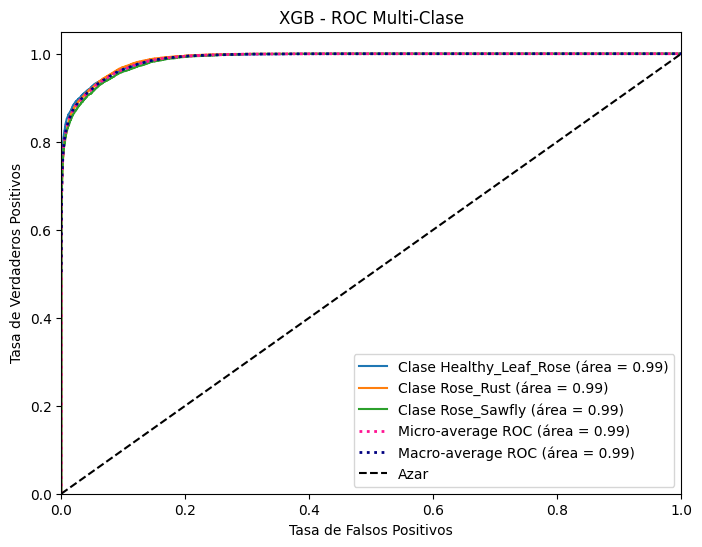

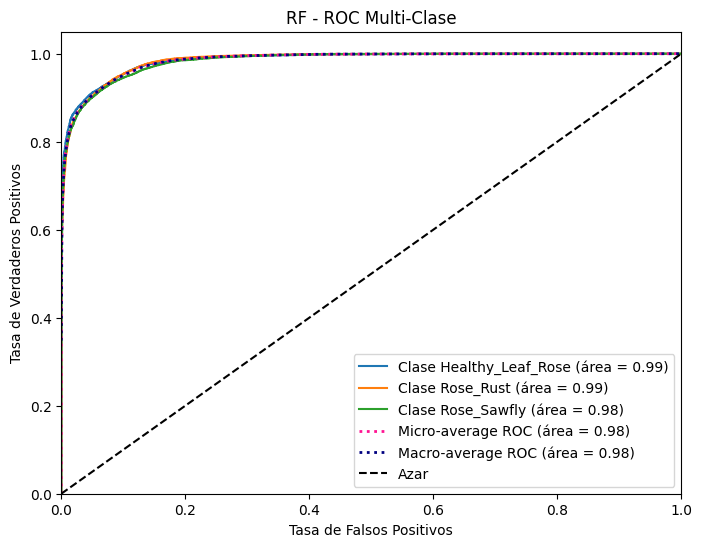

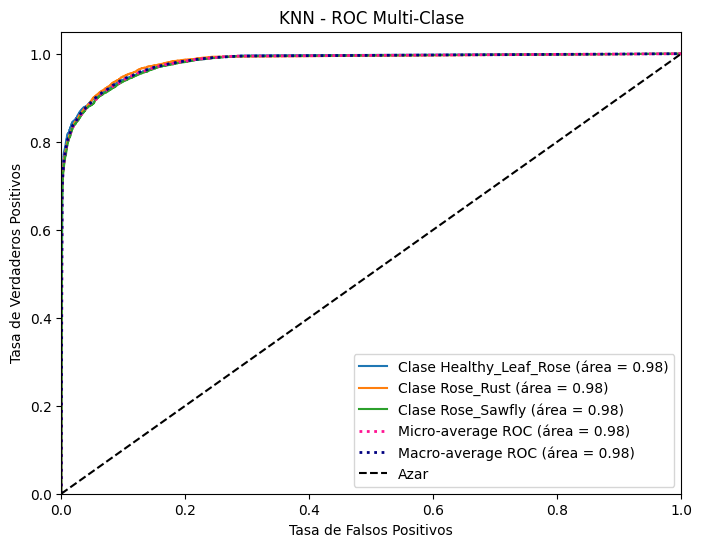

In [28]:
class_names = ["Healthy_Leaf_Rose", "Rose_Rust", "Rose_Sawfly"]
def plot_multiclass_roc(model, X_test, y_test, class_names, title="ROC Multi-Clase"):
    """
    Grafica las curvas ROC (One-vs-Rest) para cada clase.
    model: clasificador con predict_proba
    X_test, y_test: conjunto de prueba
    class_names: nombres de clases [clase0, clase1, clase2]
    """

    # Verificar si el modelo tiene predict_proba
    if not hasattr(model, "predict_proba"):
        print("El modelo no dispone de predict_proba; no se puede trazar ROC.")
        return

    # Binarizar las etiquetas de test a one-hot
    # Por ejemplo, 0 -> [1,0,0], 1 -> [0,1,0], 2 -> [0,0,1]
    y_test_bin = label_binarize(y_test, classes=[0,1,2])
    n_classes = y_test_bin.shape[1]

    # Obtener probas
    y_score = model.predict_proba(X_test)

    # fpr, tpr y roc_auc por clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average (opcional)
    # micro: concatena todas las clases y computa la curva ROC global
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average: promedio de las curvas
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Graficar
    plt.figure(figsize=(8,6))
    
    # Plot de cada clase
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Clase {class_names[i]} (área = {roc_auc[i]:.2f})")

    # Plot micro y macro promediado
    plt.plot(fpr["micro"], tpr["micro"],
             label=f"Micro-average ROC (área = {roc_auc['micro']:.2f})",
             linestyle=':', color='deeppink', linewidth=2)

    plt.plot(all_fpr, mean_tpr,
             label=f"Macro-average ROC (área = {roc_auc['macro']:.2f})",
             linestyle=':', color='navy', linewidth=2)

    # Línea diagonal
    plt.plot([0,1], [0,1], 'k--', label="Azar")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
plot_multiclass_roc(xgb_model, X_test, y_test, class_names, title="XGB - ROC Multi-Clase")
plot_multiclass_roc(rf_model, X_test, y_test, class_names, title="RF - ROC Multi-Clase")
plot_multiclass_roc(knn_model, X_test, y_test, class_names, title="KNN - ROC Multi-Clase")



=== Imagen: ..\Imagenes\test\Healthy_Leaf_Rose\brightened_IMG_20230703_211343.jpg ===
 XGB -> Predicción: Healthy_Leaf_Rose
       Probabilidades: [9.9897301e-01 1.5356021e-05 1.0116313e-03]
 RF  -> Predicción: Healthy_Leaf_Rose
       Probabilidades: [0.94661333 0.0200151  0.03337157]
 KNN -> Predicción: Healthy_Leaf_Rose
       Probabilidades: [1. 0. 0.]


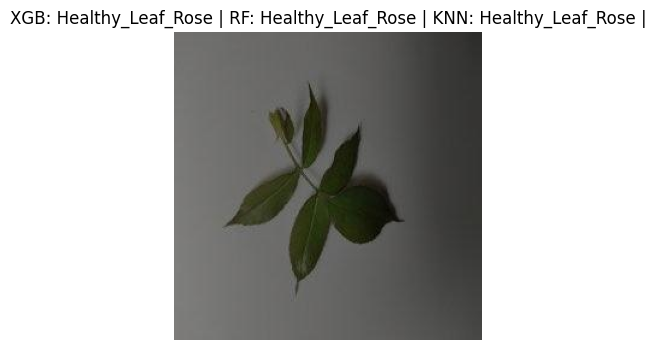


=== Imagen: ..\Imagenes\test\Rose_Rust\brightened_IMG_20230703_213438.jpg ===
 XGB -> Predicción: Rose_Rust
       Probabilidades: [4.8430538e-05 9.9993324e-01 1.8381475e-05]
 RF  -> Predicción: Rose_Rust
       Probabilidades: [3.35152597e-03 9.96535229e-01 1.13245071e-04]
 KNN -> Predicción: Rose_Rust
       Probabilidades: [0. 1. 0.]


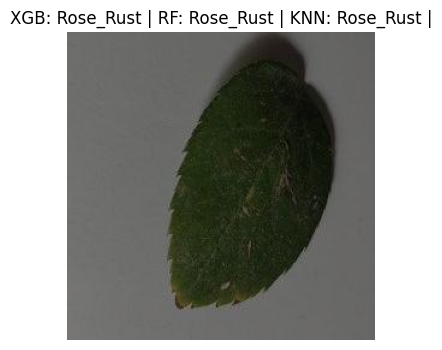


=== Imagen: ..\Imagenes\test\Rose_sawfly_Rose_slug\brightened_IMG_20230703_212412.jpg ===
 XGB -> Predicción: Rose_Sawfly
       Probabilidades: [1.80203046e-04 1.50121305e-05 9.99804795e-01]
 RF  -> Predicción: Rose_Sawfly
       Probabilidades: [8.23691812e-03 6.79504858e-04 9.91083577e-01]
 KNN -> Predicción: Rose_Sawfly
       Probabilidades: [0. 0. 1.]


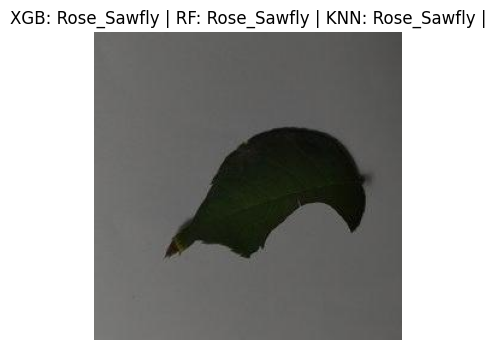

In [30]:
def predict_image_class_with_proba(img_path, sift, kmeans, model, class_dict=None):
    """
    Retorna (label_predicho, vector_probabilidades) si model tiene predict_proba,
    si no, retorna (label_predicho, None).
    """
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print("No se pudo leer la imagen:", img_path)
        return None, None

    # 1) Extraer BoVW
    bovw_vector = compute_bovw_for_image(img_bgr, sift, kmeans)
    bovw_vector_2d = bovw_vector.reshape(1, -1)

    # 2) Predicción
    pred_label = model.predict(bovw_vector_2d)[0]

    # 3) Probabilidades (si existen)
    pred_proba = None
    if hasattr(model, "predict_proba"):
        # Algunos SVC entrenados con probability=True, RF, XGB, KNN tienen predict_proba
        pred_proba = model.predict_proba(bovw_vector_2d)[0]

    # Opcional: convertir label a nombre de clase
    if class_dict:
        pred_label_str = class_dict.get(pred_label, f"Clase_{pred_label}")
    else:
        pred_label_str = str(pred_label)

    return pred_label_str, pred_proba

test_image_paths = [
    r'..\Imagenes\test\Healthy_Leaf_Rose\brightened_IMG_20230703_211343.jpg',      # Healthy
    r'..\Imagenes\test\Rose_Rust\brightened_IMG_20230703_213438.jpg',                                # Rust
    r'..\Imagenes\test\Rose_sawfly_Rose_slug\brightened_IMG_20230703_212412.jpg'                             # Sawfly
]


for img_path in test_image_paths:
    print(f"\n=== Imagen: {img_path} ===")

    # XGB
    label_xgb, proba_xgb = predict_image_class_with_proba(img_path, sift, kmeans, xgb_model, class_dict)
    print(" XGB -> Predicción:", label_xgb)
    if proba_xgb is not None:
        print("       Probabilidades:", proba_xgb)  # array con pClase0, pClase1, pClase2
    else:
        print("       (Este modelo no tiene predict_proba)")

    # RF
    label_rf, proba_rf = predict_image_class_with_proba(img_path, sift, kmeans, rf_model, class_dict)
    print(" RF  -> Predicción:", label_rf)
    if proba_rf is not None:
        print("       Probabilidades:", proba_rf)
    else:
        print("       (Este modelo no tiene predict_proba)")

    # KNN
    label_knn, proba_knn = predict_image_class_with_proba(img_path, sift, kmeans, knn_model, class_dict)
    print(" KNN -> Predicción:", label_knn)
    if proba_knn is not None:
        print("       Probabilidades:", proba_knn)
    else:
        print("       (Este modelo no tiene predict_proba)")

    # SVM (Lineal)
    # Asumiendo que se llama svm_model
 

    # Visualizar la imagen (opcional)
    img_bgr = cv2.imread(img_path)
    if img_bgr is not None:
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6,4))
        plt.imshow(img_rgb)
        plt.title(f"XGB: {label_xgb} | RF: {label_rf} | KNN: {label_knn} |")
        plt.axis("off")
        plt.show()


## 9. Aprendizaje no supervisado (Unsupervised) para segmentación de color o agrupamiento de texturas, así como para etiquetado automático.

In [ ]:
X_bovw, y_labels = joblib.load('Models\\bovw_features_labels.pkl')
print("X_bovw shape:", X_bovw.shape)

# 1. Aplicamos KMeans con 3 clústeres
k = 3
kmeans_unsup = KMeans(n_clusters=k, random_state=42)
kmeans_unsup.fit(X_bovw)
clusters = kmeans_unsup.predict(X_bovw)

# 2. Métricas para evaluar qué tan parecido es el clustering a las clases reales
ari = adjusted_rand_score(y_labels, clusters)
homog = homogeneity_score(y_labels, clusters)

print("=== Clustering BoVW (Unsupervised) ===")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Homogeneity Score:   {homog:.4f}")

# 3. Opcionalmente, ver la matriz de confusión para ver la correspondencia
cm = confusion_matrix(y_labels, clusters)
print("Confusion Matrix (rows=clase real, cols=cluster):")
print(cm)

# Observa cuántas imágenes de la clase X cayeron en el cluster Y, etc.
# Si ves que un cluster corresponde mayoritariamente a "Healthy", otro a "Rust", etc.,
# significa que el método no supervisado está capturando algo de la enfermedad.

X_bovw shape: (175886, 100)
=== Clustering BoVW (Unsupervised) ===
Adjusted Rand Index: 0.0002
Homogeneity Score:   0.0008
Confusion Matrix (rows=clase real, cols=cluster):
[[24115 30029  4453]
 [25136 30466  3050]
 [24693 30343  3601]]


In [ ]:
p = '..\\Imagenes\\test\\Healthy_Leaf_Rose\\brightened_IMG_20230703_211343.jpg'
print("Ruta:", p)
print("Existe?", os.path.exists(p))


Ruta: ..\data\archive\Rose\test\Healthy_Leaf_Rose\brightened_IMG_20230703_211343.jpg
Existe? True


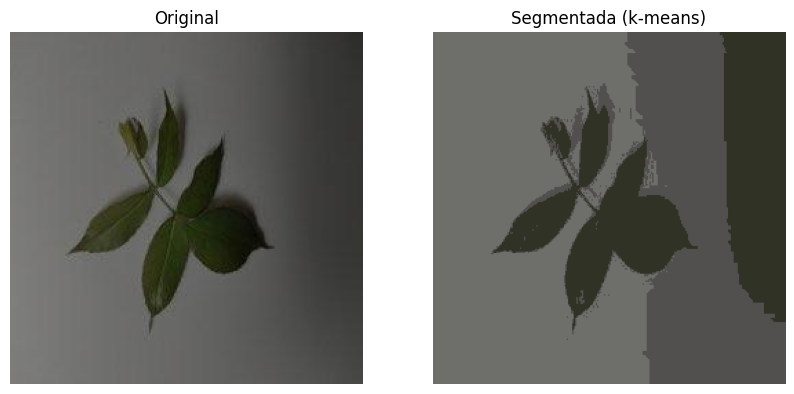

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def segment_image_kmeans(image_bgr, k=3):
    """
    Segmenta la imagen en k regiones basadas en color con k-means.
    Retorna la imagen segmentada.
    """
    # Convertir a RGB para matplotlib
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    h, w = image_rgb.shape[:2]
    
    # Aplanar la imagen a Nx3
    image_reshaped = image_rgb.reshape(-1, 3)

    # Aplicar KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(image_reshaped)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_.astype(np.uint8)

    # Reconstruir la imagen segmentada con los centroides
    segmented_reshaped = centers[labels.flatten()]
    segmented_image = segmented_reshaped.reshape((h, w, 3))

    return image_rgb, segmented_image

# Ejemplo de uso:
img_path = '..\\Imagenes\\test\\Healthy_Leaf_Rose\\brightened_IMG_20230703_211343.jpg'
img_bgr = cv2.imread(img_path)
if img_bgr is not None:
    orig, seg = segment_image_kmeans(img_bgr, k=3)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(seg)
    plt.title("Segmentada (k-means)")
    plt.axis('off')
    plt.show()
else:
    print("No se pudo leer la imagen.")
